In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using device: cuda
Creating vit_base_patch16_384 model...


model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

Epoch 1/30, Train Loss: 1.7492, Val Acc: 0.2004
Saved new best model with val acc: 0.2004
Epoch 2/30, Train Loss: 0.2983, Val Acc: 0.8472
Saved new best model with val acc: 0.8472
Epoch 4/30, Train Loss: 0.1508, Val Acc: 0.8373
Epoch 5/30, Train Loss: 0.1147, Val Acc: 0.8760
Epoch 6/30, Train Loss: 0.1033, Val Acc: 0.8343
Epoch 7/30, Train Loss: 0.1041, Val Acc: 0.8829
Saved new best model with val acc: 0.8829
Epoch 8/30, Train Loss: 0.0814, Val Acc: 0.9092
Saved new best model with val acc: 0.9092
Epoch 9/30, Train Loss: 0.0670, Val Acc: 0.9038
Epoch 11/30, Train Loss: 0.0666, Val Acc: 0.8909
Epoch 12/30, Train Loss: 0.0511, Val Acc: 0.9191
Saved new best model with val acc: 0.9191
Epoch 13/30, Train Loss: 0.0461, Val Acc: 0.8988
Epoch 14/30, Train Loss: 0.0364, Val Acc: 0.9117
Epoch 15/30, Train Loss: 0.0353, Val Acc: 0.9177
Epoch 16/30, Train Loss: 0.0295, Val Acc: 0.9236
Saved new best model with val acc: 0.9236
Epoch 17/30, Train Loss: 0.0246, Val Acc: 0.9167
Epoch 18/30, Train Lo

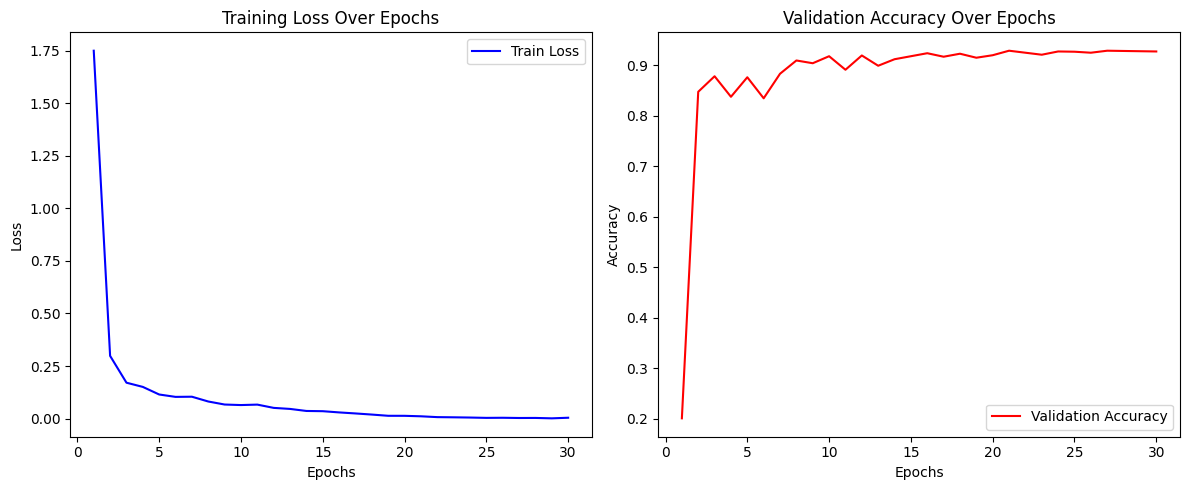

Final trained model saved to /kaggle/working/vit_final_model.pth

Final Test Accuracy: 0.9264 (92.64%)


In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import numpy as np
import torch.nn.functional as F
import timm
from PIL import Image
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

# Define dataset directories (for Kaggle)
data_dir = "/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Image parameters
img_size = 384
batch_size = 16  # Adjust batch size for memory efficiency

# Transformations
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_transform)
test_dataset = ImageFolder(test_dir, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define model saving path
model_save_path = "/kaggle/working/vit_best_model.pth"
final_model_path = "/kaggle/working/vit_final_model.pth"

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        f_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return torch.mean(f_loss)
        else:
            return f_loss

# Get Transformer model
def get_transformer_model(model_name, num_classes):
    print(f"Creating {model_name} model...")
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    return model.to(device)

# Evaluate model
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Function to plot training loss and validation accuracy
def plot_training_curves(train_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Training function
def train_transformer(model, train_loader, val_loader, num_epochs=30):
    criterion = FocalLoss(gamma=2)
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.05)

    # Learning rate warmup & cosine decay
    def warmup_cosine_schedule(epoch):
        warmup_epochs = 3
        if epoch < warmup_epochs:
            return epoch / warmup_epochs
        else:
            return 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (num_epochs - warmup_epochs)))

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, warmup_cosine_schedule)

    best_val_acc = 0.0
    best_model_wts = None
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        val_acc = evaluate_model(model, val_loader)

        train_losses.append(avg_train_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step()

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, model_save_path)  # Save best model
            print(f"Saved new best model with val acc: {best_val_acc:.4f}")

    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    # Plot training results
    plot_training_curves(train_losses, val_accuracies)

    return model

# Run the pipeline
if __name__ == "__main__":
    model_name = "vit_base_patch16_384"
    model = get_transformer_model(model_name, num_classes=len(train_dataset.classes))

    trained_model = train_transformer(model, train_loader, val_loader, num_epochs=30)

    # Save final trained model
    torch.save(trained_model.state_dict(), final_model_path)
    print(f"Final trained model saved to {final_model_path}")

    test_accuracy = evaluate_model(trained_model, test_loader)
    print(f"\nFinal Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


Epoch 1/20, Train Loss: 0.8765, Val Loss: 0.7238, Val Acc: 0.8279
Epoch 2/20, Train Loss: 0.7273, Val Loss: 0.6745, Val Acc: 0.8552
Epoch 3/20, Train Loss: 0.6921, Val Loss: 0.6717, Val Acc: 0.8482
Epoch 4/20, Train Loss: 0.6697, Val Loss: 0.6709, Val Acc: 0.8452
Epoch 5/20, Train Loss: 0.6738, Val Loss: 0.6450, Val Acc: 0.8631
Epoch 6/20, Train Loss: 0.6400, Val Loss: 0.6370, Val Acc: 0.8601
Epoch 7/20, Train Loss: 0.6205, Val Loss: 0.6342, Val Acc: 0.8710
Epoch 8/20, Train Loss: 0.6178, Val Loss: 0.6319, Val Acc: 0.8720
Epoch 9/20, Train Loss: 0.6026, Val Loss: 0.6174, Val Acc: 0.8760
Epoch 10/20, Train Loss: 0.5946, Val Loss: 0.6296, Val Acc: 0.8829
Epoch 11/20, Train Loss: 0.5825, Val Loss: 0.6081, Val Acc: 0.8849
Epoch 12/20, Train Loss: 0.5756, Val Loss: 0.6164, Val Acc: 0.8874
Epoch 13/20, Train Loss: 0.5800, Val Loss: 0.6101, Val Acc: 0.8909
Epoch 14/20, Train Loss: 0.5668, Val Loss: 0.6096, Val Acc: 0.8805
Epoch 15/20, Train Loss: 0.5688, Val Loss: 0.6095, Val Acc: 0.8859
Epoc

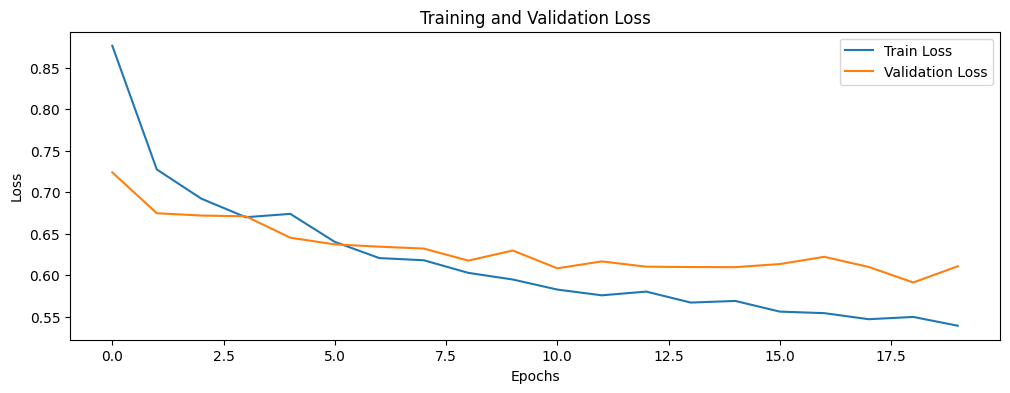

Model saved to /kaggle/working/fine_tuned_densenet121_lung.pth


In [3]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet121, DenseNet121_Weights
import matplotlib.pyplot as plt
import os

# Define dataset directories (for Kaggle)
data_dir = "/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Image parameters
img_size = 224
batch_size = 32

# Data augmentation & preprocessing
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = ImageFolder(train_dir, transform=transform)
val_dataset = ImageFolder(val_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load DenseNet121 model with pre-trained weights
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
num_features = model.classifier.in_features

# Modify classifier
model.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, len(train_dataset.classes)),  # Output layer based on number of classes
    nn.LogSoftmax(dim=1)
)

# Fine-tune last dense block
for name, param in model.named_parameters():
    if "denseblock4" in name or "classifier" in name:
        param.requires_grad = True  # Unfreeze last dense block and classifier
    else:
        param.requires_grad = False  # Freeze earlier layers

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function (CrossEntropy with Label Smoothing)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Use AdamW optimizer (instead of Ranger)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop
epochs = 20
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracy = correct / total

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.4f}")

# Test accuracy
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Save the fine-tuned model to Kaggle working directory
model_save_path = "/kaggle/working/fine_tuned_densenet121_lung.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Using device: cuda
Epoch 1/20, Train Loss: 1.6053, Train Acc: 0.2550, Val Loss: 1.5981, Val Acc: 0.3740
Epoch 2/20, Train Loss: 1.5882, Train Acc: 0.3756, Val Loss: 1.5731, Val Acc: 0.4509
Epoch 3/20, Train Loss: 1.5455, Train Acc: 0.4927, Val Loss: 1.5175, Val Acc: 0.5675
Epoch 4/20, Train Loss: 1.4449, Train Acc: 0.5743, Val Loss: 1.3771, Val Acc: 0.6285
Epoch 5/20, Train Loss: 1.3010, Train Acc: 0.6059, Val Loss: 1.2192, Val Acc: 0.6687
Epoch 6/20, Train Loss: 1.1737, Train Acc: 0.6392, Val Loss: 1.0900, Val Acc: 0.6979
Epoch 7/20, Train Loss: 1.0893, Train Acc: 0.6662, Val Loss: 1.0402, Val Acc: 0.6989
Epoch 8/20, Train Loss: 1.0338, Train Acc: 0.6776, Val Loss: 1.0375, Val Acc: 0.7416
Epoch 9/20, Train Loss: 0.9866, Train Acc: 0.6974, Val Loss: 0.9489, Val Acc: 0.7465
Epoch 10/20, Train Loss: 0.9408, Train Acc: 0.7250, Val Loss: 0.8881, Val Acc: 0.7579
Epoch 11/20, Train Loss: 0.9300, Train Acc: 0.7232, Val Loss: 0.9088, Val Acc: 0.7535
Epoch 12/20, Train Loss: 0.9153, Train Acc: 

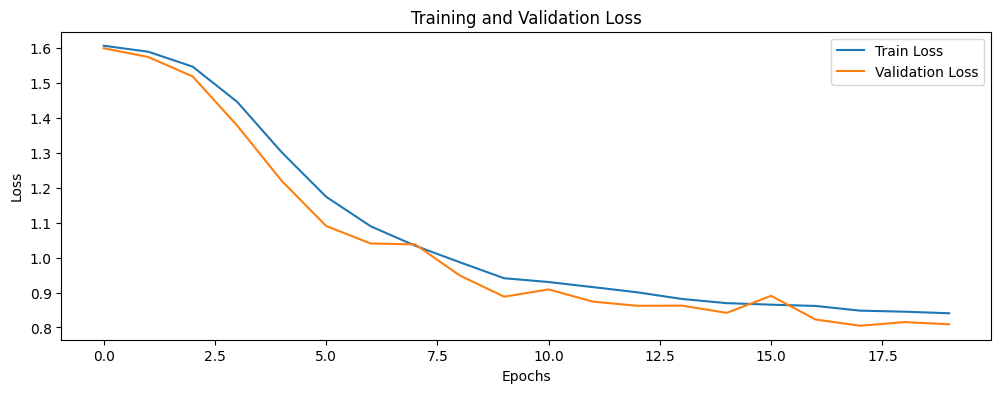

Model saved to /kaggle/working/fine_tuned_efficientnet_b3.pth


In [7]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os

# ✅ Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Define dataset directories (for Kaggle)
data_dir = "/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# ✅ Image parameters
img_size = 300  # Larger image size for EfficientNet-B3
batch_size = 32

# ✅ Data augmentation & preprocessing
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ Load dataset
train_dataset = ImageFolder(train_dir, transform=transform)
val_dataset = ImageFolder(val_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ✅ Load EfficientNet-B3 model with pre-trained weights
model = models.efficientnet_b3(weights="IMAGENET1K_V1")
num_features = model.classifier[1].in_features  # Get input features of the classifier

# ✅ Modify classifier
model.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, len(train_dataset.classes)),  # Output layer based on number of classes
    nn.LogSoftmax(dim=1)
)

# ✅ Fine-tune last few layers
for name, param in model.named_parameters():
    if "blocks.5" in name or "blocks.6" in name or "classifier" in name:
        param.requires_grad = True  # Unfreeze last few blocks & classifier
    else:
        param.requires_grad = False  # Freeze earlier layers

# ✅ Move model to GPU
model = model.to(device)

# ✅ Loss function (CrossEntropy with Label Smoothing)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# ✅ Lookahead Optimizer (Fixed)
class Lookahead(optim.Optimizer):
    def __init__(self, base_optimizer, k=5, alpha=0.5):
        self.base_optimizer = base_optimizer
        self.k = k
        self.alpha = alpha
        self.counter = 0
        self.slow_weights = [p.clone().detach() for p in base_optimizer.param_groups[0]["params"]]

    def step(self):
        self.base_optimizer.step()
        self.counter += 1

        if self.counter >= self.k:
            for i, p in enumerate(self.base_optimizer.param_groups[0]["params"]):
                p.data = self.slow_weights[i] + self.alpha * (p.data - self.slow_weights[i])
                self.slow_weights[i] = p.clone().detach()
            self.counter = 0

# ✅ Use RAdam optimizer with Lookahead
base_optimizer = optim.RAdam(model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = Lookahead(base_optimizer)

# ✅ Apply One-Cycle Learning Rate Scheduler on base_optimizer
scheduler = optim.lr_scheduler.OneCycleLR(
    base_optimizer,  # <-- Apply on base_optimizer, not Lookahead
    max_lr=0.001, 
    steps_per_epoch=len(train_loader), 
    epochs=20
)

# ✅ Training loop
epochs = 20
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.base_optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()
    train_losses.append(running_loss / len(train_loader))
    train_accuracy = correct / total

    # ✅ Validation
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracy = correct / total

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.4f}")

# ✅ Test accuracy
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

# ✅ Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# ✅ Save the fine-tuned model
model_save_path = "/kaggle/working/fine_tuned_efficientnet_b3.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Using device: cuda
Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.0002

Important - num_epochs of training = ** 20 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 836 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 2735 of 3800
warm down will decay until 3e-05 lr
params size saved
total param groups = 1
total params in groups = 422
Epoch 1/20, Train Loss: 1.6078, Val Loss: 1.6011, Val Acc: 0.3591
Epoch 2/20, Train Loss: 1.5843, Val Loss: 1.5511, Val Acc: 0.5670
Epoch 3/20, Train Loss: 1.4803, Val Loss: 1.3715, Val Acc: 0.5784
Epoch 4/20, Train Loss: 1.2440, Val Loss: 1.1019, Val Acc: 0.6820

** Ranger21 update = Warmup co

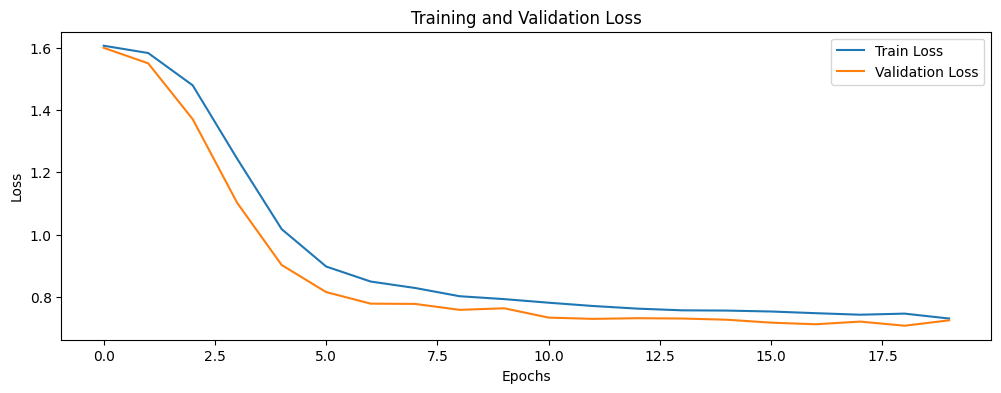

Model saved to /kaggle/working/fine_tuned_efficientnetb4_lung.pth


In [12]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os

# ✅ Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Dataset Paths (for Kaggle)
data_dir = "/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# ✅ Image parameters
img_size = 380  # EfficientNet-B4 requires 380x380 input
batch_size = 32

# ✅ Data Augmentation & Preprocessing
transform_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ Load dataset
train_dataset = ImageFolder(train_dir, transform=transform_train)
val_dataset = ImageFolder(val_dir, transform=transform_val_test)
test_dataset = ImageFolder(test_dir, transform=transform_val_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# ✅ Load EfficientNet-B4 with Pretrained Weights
model = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)
num_features = model.classifier[1].in_features

# ✅ Modify Classifier for Lung Disease Classification
model.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, len(train_dataset.classes)),  # Output layer based on the number of classes
    nn.LogSoftmax(dim=1)
)

# ✅ Fine-tune last blocks
for name, param in model.named_parameters():
    if "blocks.5" in name or "blocks.6" in name or "classifier" in name:
        param.requires_grad = True  # Unfreeze last layers & classifier
    else:
        param.requires_grad = False  # Freeze early layers

model = model.to(device)

# ✅ Loss Function (CrossEntropy with Label Smoothing)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# ✅ Ranger Optimizer (RAdam + Lookahead)
from ranger21 import Ranger21  # Install via pip if needed
num_batches_per_epoch = len(train_loader)
optimizer = Ranger21(model.parameters(), lr=2e-4, num_batches_per_epoch=num_batches_per_epoch, num_epochs=20, weight_decay=1e-3)

# ✅ Cosine Annealing LR Scheduler with Warmup
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# ✅ Training loop
epochs = 20
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    train_losses.append(running_loss / len(train_loader))

    # ✅ Validation
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracy = correct / total

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.4f}")

# ✅ Test Accuracy
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

# ✅ Plot Training & Validation Loss
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# ✅ Save Model
model_save_path = "/kaggle/working/fine_tuned_efficientnetb4_lung.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


In [9]:
pip install ranger21


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm  # Progress bar

# ✅ Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Dataset Paths (for Kaggle)
data_dir = "/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# ✅ Image parameters
img_size = 380  # EfficientNet-B4 requires 380x380 input
batch_size = 32

# ✅ Data Augmentation & Preprocessing
transform_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ Load dataset
train_dataset = ImageFolder(train_dir, transform=transform_train)
val_dataset = ImageFolder(val_dir, transform=transform_val_test)
test_dataset = ImageFolder(test_dir, transform=transform_val_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# ✅ Load EfficientNet-B4 with Pretrained Weights
model = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)
num_features = model.classifier[1].in_features

# ✅ Modify Classifier for Lung Disease Classification
model.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, len(train_dataset.classes)),  # Output layer based on the number of classes
    nn.LogSoftmax(dim=1)
)

# ✅ Fine-tune last 3 blocks for better feature extraction
for name, param in model.named_parameters():
    if "blocks.4" in name or "blocks.5" in name or "blocks.6" in name or "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model = model.to(device)

# ✅ Loss Function (CrossEntropy with Label Smoothing)
criterion = nn.CrossEntropyLoss(label_smoothing=0.15)

# ✅ AdamW Optimizer with better weight decay
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

# ✅ Cosine Annealing LR Scheduler with Warmup
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# ✅ Mixed Precision Training (Speeds up training)
scaler = torch.cuda.amp.GradScaler()

# ✅ Early Stopping
best_val_acc = 0.0
early_stop_count = 0
patience = 5  # Stop if validation accuracy doesn't improve for 5 epochs

# ✅ Training loop
epochs = 30
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0
    loop = tqdm(train_loader, leave=True)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        loop.set_postfix(loss=loss.item())

    scheduler.step()
    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)

    # ✅ Validation
    model.eval()
    val_loss = 0.0
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val
    val_losses.append(val_loss)

    print(f"\nEpoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # ✅ Save Best Model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/kaggle/working/best_model.pth")
        print(f"🔥 Best model saved with Val Acc: {val_acc:.4f}")
        early_stop_count = 0
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            print("⏹️ Early stopping triggered. Stopping training.")
            break

# ✅ Load Best Model
model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))

# ✅ Test Accuracy
correct, total = 0, 0
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

# ✅ Plot Training & Validation Loss
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


Using device: cuda
Training a single model...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 148MB/s]


Epoch 1/40, Train Loss: 0.3610, Val Loss: 0.2796, Val Acc: 0.8428, LR: 0.000300
New best model with validation accuracy: 0.8428
Epoch 2/40, Train Loss: 0.2764, Val Loss: 0.1684, Val Acc: 0.8378, LR: 0.000298
Epoch 3/40, Train Loss: 0.2243, Val Loss: 0.1785, Val Acc: 0.8532, LR: 0.000296
New best model with validation accuracy: 0.8532
Epoch 4/40, Train Loss: 0.2455, Val Loss: 0.3011, Val Acc: 0.8596, LR: 0.000293
New best model with validation accuracy: 0.8596
Epoch 5/40, Train Loss: 0.2102, Val Loss: 0.1755, Val Acc: 0.8621, LR: 0.000289
New best model with validation accuracy: 0.8621
Epoch 6/40, Train Loss: 0.2078, Val Loss: 0.1221, Val Acc: 0.8666, LR: 0.000284
New best model with validation accuracy: 0.8666
Epoch 7/40, Train Loss: 0.2093, Val Loss: 1.0165, Val Acc: 0.8745, LR: 0.000278
New best model with validation accuracy: 0.8745
Epoch 8/40, Train Loss: 0.2001, Val Loss: 0.2775, Val Acc: 0.8745, LR: 0.000271
Epoch 9/40, Train Loss: 0.1931, Val Loss: 0.2384, Val Acc: 0.8681, LR: 0

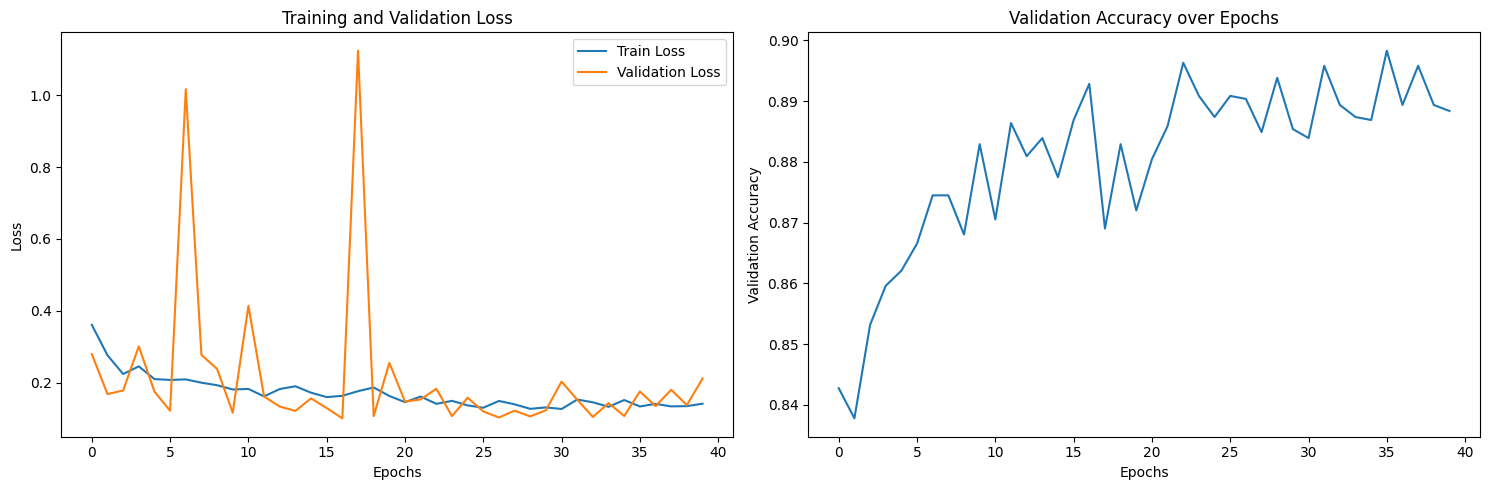

Single model saved to /kaggle/working/efficientnet_b0_lung.pth
Ensemble model 1 saved to /kaggle/working/ensemble_model_1.pth
Ensemble model 2 saved to /kaggle/working/ensemble_model_2.pth
Ensemble model 3 saved to /kaggle/working/ensemble_model_3.pth


In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import KFold
import torch.nn.functional as F
import copy
from PIL import Image

# Define dataset directories (for Kaggle)
data_dir = "/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Image parameters
img_size = 256  # Increased from 224
batch_size = 32

# Enhanced data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Reduced rotation angle for medical images
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Less aggressive transform for validation and test
val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_transform)
test_dataset = ImageFolder(test_dir, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Define class weights if needed (uncomment and set if dataset is imbalanced)
# class_counts = [0] * len(train_dataset.classes)
# for _, label in train_dataset:
#     class_counts[label] += 1
# class_weights = torch.FloatTensor([len(train_dataset) / (len(train_dataset.classes) * count) for count in class_counts])
# class_weights = class_weights.to(device)

# Focal Loss for handling potential class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        f_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return torch.mean(f_loss)
        else:
            return f_loss

# Mixup implementation for better generalization
def mixup_data(x, y, alpha=0.2, device='cuda'):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Function for test-time augmentation
def test_time_augmentation(model, images, device, num_augments=5):
    batch_size = images.size(0)
    predictions = []
    
    # Original prediction
    with torch.no_grad():
        outputs = model(images)
        predictions.append(F.softmax(outputs, dim=1))
    
    # Apply augmentations
    for _ in range(num_augments - 1):
        augmented_images = images.clone()
        
        # Random horizontal flip
        flip_mask = torch.rand(batch_size) > 0.5
        for i, should_flip in enumerate(flip_mask):
            if should_flip:
                augmented_images[i] = torch.flip(augmented_images[i], [2])  # Flip horizontally
                
        # Get predictions on augmented images
        with torch.no_grad():
            outputs = model(augmented_images)
            predictions.append(F.softmax(outputs, dim=1))
    
    # Average predictions
    avg_predictions = torch.stack(predictions).mean(dim=0)
    return avg_predictions

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to create and configure model
def get_model(num_classes):
    # Using EfficientNet B0 instead of DenseNet
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    
    # Modify classifier
    in_features = model._modules['classifier'][1].in_features
    model._modules['classifier'] = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=in_features, out_features=512),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(in_features=512, out_features=num_classes)
    )
    
    # Unfreeze last several layers for fine-tuning
    for name, param in model.named_parameters():
        if "features.7" in name or "features.8" in name or "classifier" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
    
    return model.to(device)

# Main training function
def train_model(model, train_loader, val_loader, num_epochs=30):
    # Loss function and optimizer
    criterion = FocalLoss(gamma=2)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), 
                          lr=0.0003, weight_decay=2e-4)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    best_val_accuracy = 0.0
    best_model_weights = None
    train_losses, val_losses, val_accuracies = [], [], []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Apply mixup with 50% probability
            use_mixup = np.random.random() > 0.5
            if use_mixup:
                images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=0.2, device=device)
                
            optimizer.zero_grad()
            outputs = model(images)
            
            if use_mixup:
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            else:
                loss = criterion(outputs, labels)
                
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_val_loss = val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        
        # Update learning rate
        scheduler.step()
        
        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, "
              f"Val Acc: {val_accuracy:.4f}, "
              f"LR: {scheduler.get_last_lr()[0]:.6f}")
        
        # Save best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_weights = copy.deepcopy(model.state_dict())
            print(f"New best model with validation accuracy: {best_val_accuracy:.4f}")
    
    # Load best model weights
    model.load_state_dict(best_model_weights)
    return model, train_losses, val_losses, val_accuracies, best_val_accuracy

# Train multiple models for ensemble
def train_ensemble(num_models=3):
    models = []
    val_accuracies = []
    
    for i in range(num_models):
        print(f"\nTraining model {i+1}/{num_models}")
        model = get_model(num_classes=len(train_dataset.classes))
        trained_model, _, _, _, val_acc = train_model(
            model, train_loader, val_loader, num_epochs=30)
        models.append(trained_model)
        val_accuracies.append(val_acc)
        
    return models, val_accuracies

# Evaluate ensemble on test set with test-time augmentation
def evaluate_ensemble(models, test_loader, use_tta=True):
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            all_labels.append(labels)
            
            batch_predictions = []
            for model in models:
                model.eval()
                
                if use_tta:
                    # Use test-time augmentation
                    probs = test_time_augmentation(model, images, device)
                else:
                    outputs = model(images)
                    probs = F.softmax(outputs, dim=1)
                
                batch_predictions.append(probs)
            
            # Average predictions from all models
            avg_preds = torch.stack(batch_predictions).mean(dim=0)
            all_predictions.append(avg_preds)
    
    # Concatenate all batches
    all_predictions = torch.cat(all_predictions, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Calculate accuracy
    _, predicted_classes = torch.max(all_predictions, dim=1)
    accuracy = (predicted_classes == all_labels).float().mean().item()
    
    return accuracy

# Main execution
if __name__ == "__main__":
    # Option 1: Train a single model with extended training time
    print("Training a single model...")
    model = get_model(num_classes=len(train_dataset.classes))
    single_model, train_losses, val_losses, val_accuracies, best_val_acc = train_model(
        model, train_loader, val_loader, num_epochs=40)
    
    # Test the single model with test-time augmentation
    model.eval()
    correct, total = 0, 0
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Apply test-time augmentation
        probs = test_time_augmentation(model, images, device)
        _, predicted = torch.max(probs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    single_model_accuracy = correct / total
    print(f"Single Model Test Accuracy with TTA: {single_model_accuracy:.4f}")
    
    # Option 2: Train an ensemble of models
    print("\nTraining ensemble models...")
    ensemble_models, ensemble_val_accs = train_ensemble(num_models=3)
    
    # Evaluate ensemble with test-time augmentation
    ensemble_accuracy = evaluate_ensemble(ensemble_models, test_loader, use_tta=True)
    print(f"Ensemble Test Accuracy with TTA: {ensemble_accuracy:.4f}")
    
    # Plot training and validation loss
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy over Epochs')
    
    plt.tight_layout()
    plt.show()
    
    # Save the best model(s)
    model_save_path = "/kaggle/working/efficientnet_b0_lung.pth"
    torch.save(single_model.state_dict(), model_save_path)
    print(f"Single model saved to {model_save_path}")
    
    # Save ensemble models
    for i, model in enumerate(ensemble_models):
        ensemble_save_path = f"/kaggle/working/ensemble_model_{i+1}.pth"
        torch.save(model.state_dict(), ensemble_save_path)
        print(f"Ensemble model {i+1} saved to {ensemble_save_path}")

**Transformers**

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import numpy as np
import torch.nn.functional as F
import timm
from PIL import Image
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

# Define dataset directories (for Kaggle)
data_dir = "/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Image parameters
img_size = 384
batch_size = 16  # Adjust batch size for memory efficiency

# Transformations
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_transform)
test_dataset = ImageFolder(test_dir, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define model saving path
model_save_path = "/kaggle/working/best_model.pth"
final_model_path = "/kaggle/working/final_model.pth"

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        f_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return torch.mean(f_loss)
        else:
            return f_loss

# Get Transformer model
def get_transformer_model(model_name, num_classes):
    print(f"Creating {model_name} model...")
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    return model.to(device)

# Training function
def train_transformer(model, train_loader, val_loader, num_epochs=30):
    criterion = FocalLoss(gamma=2)
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.05)

    # Learning rate warmup & cosine decay
    def warmup_cosine_schedule(epoch):
        warmup_epochs = 3
        if epoch < warmup_epochs:
            return epoch / warmup_epochs
        else:
            return 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (num_epochs - warmup_epochs)))
    
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, warmup_cosine_schedule)

    best_val_acc = 0.0
    best_model_wts = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            running_loss += loss.item()

        val_acc = evaluate_model(model, val_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step()
        
        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, model_save_path)  # Save best model
            print(f"Saved new best model with val acc: {best_val_acc:.4f}")

    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model

# Evaluate model
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Run the pipeline
if __name__ == "__main__":
    model_name = "vit_base_patch16_384"
    model = get_transformer_model(model_name, num_classes=len(train_dataset.classes))
    
    trained_model = train_transformer(model, train_loader, val_loader, num_epochs=20)

    # Save final trained model
    torch.save(trained_model.state_dict(), final_model_path)
    print(f"Final trained model saved to {final_model_path}")

    test_accuracy = evaluate_model(trained_model, test_loader)
    print(f"\nFinal Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


Using device: cuda
Creating vit_base_patch16_384 model...


model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

Epoch 1/20, Train Loss: 2.1793, Val Acc: 0.1776
Saved new best model with val acc: 0.1776
Epoch 2/20, Train Loss: 0.2930, Val Acc: 0.8502
Saved new best model with val acc: 0.8502
Epoch 3/20, Train Loss: 0.1718, Val Acc: 0.8730
Saved new best model with val acc: 0.8730
Epoch 4/20, Train Loss: 0.1494, Val Acc: 0.8824
Saved new best model with val acc: 0.8824
Epoch 5/20, Train Loss: 0.1157, Val Acc: 0.8452
Epoch 6/20, Train Loss: 0.1043, Val Acc: 0.8621
Epoch 7/20, Train Loss: 0.0902, Val Acc: 0.8869
Saved new best model with val acc: 0.8869
Epoch 8/20, Train Loss: 0.0847, Val Acc: 0.8938
Saved new best model with val acc: 0.8938
Epoch 9/20, Train Loss: 0.0675, Val Acc: 0.9112
Saved new best model with val acc: 0.9112
Epoch 10/20, Train Loss: 0.0594, Val Acc: 0.9112
Epoch 11/20, Train Loss: 0.0495, Val Acc: 0.9236
Saved new best model with val acc: 0.9236
Epoch 12/20, Train Loss: 0.0465, Val Acc: 0.9162
Epoch 13/20, Train Loss: 0.0317, Val Acc: 0.9043
Epoch 14/20, Train Loss: 0.0285, Val

In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import numpy as np
import torch.nn.functional as F
import timm
from PIL import Image
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

# Define dataset directories (for Kaggle)
data_dir = "/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Image parameters
img_size = 384
batch_size = 16  # Adjust batch size for memory efficiency

# Transformations
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_transform)
test_dataset = ImageFolder(test_dir, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define model saving path
model_save_path = "/kaggle/working/best_model.pth"
final_model_path = "/kaggle/working/final_model.pth"

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        f_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return torch.mean(f_loss)
        else:
            return f_loss

# Get Transformer model
def get_transformer_model(model_name, num_classes):
    print(f"Creating {model_name} model...")
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    return model.to(device)

# Training function
def train_transformer(model, train_loader, val_loader, num_epochs=30):
    criterion = FocalLoss(gamma=2)
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.05)

    # Learning rate warmup & cosine decay
    def warmup_cosine_schedule(epoch):
        warmup_epochs = 3
        if epoch < warmup_epochs:
            return epoch / warmup_epochs
        else:
            return 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (num_epochs - warmup_epochs)))
    
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, warmup_cosine_schedule)

    best_val_acc = 0.0
    best_model_wts = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            running_loss += loss.item()

        val_acc = evaluate_model(model, val_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step()
        
        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, model_save_path)  # Save best model
            print(f"Saved new best model with val acc: {best_val_acc:.4f}")

    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model

# Evaluate model
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Run the pipeline
if __name__ == "__main__":
    model_name = "vit_base_patch16_384"
    model = get_transformer_model(model_name, num_classes=len(train_dataset.classes))
    
    trained_model = train_transformer(model, train_loader, val_loader, num_epochs=20)

    # Save final trained model
    torch.save(trained_model.state_dict(), final_model_path)
    print(f"Final trained model saved to {final_model_path}")

    test_accuracy = evaluate_model(trained_model, test_loader)
    print(f"\nFinal Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


Using device: cuda
Creating vit_base_patch16_384 model...


model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

Epoch 1/20, Train Loss: 2.1622, Val Acc: 0.1949
Saved new best model with val acc: 0.1949
Epoch 2/20, Train Loss: 0.3007, Val Acc: 0.8576
Saved new best model with val acc: 0.8576
Epoch 3/20, Train Loss: 0.1772, Val Acc: 0.8854
Saved new best model with val acc: 0.8854
Epoch 4/20, Train Loss: 0.1476, Val Acc: 0.8904
Saved new best model with val acc: 0.8904
Epoch 5/20, Train Loss: 0.1220, Val Acc: 0.8859
Epoch 6/20, Train Loss: 0.0981, Val Acc: 0.8611
Epoch 7/20, Train Loss: 0.0893, Val Acc: 0.9008
Saved new best model with val acc: 0.9008
Epoch 8/20, Train Loss: 0.0798, Val Acc: 0.9087
Saved new best model with val acc: 0.9087
Epoch 9/20, Train Loss: 0.0659, Val Acc: 0.9167
Saved new best model with val acc: 0.9167
Epoch 10/20, Train Loss: 0.0576, Val Acc: 0.9087
Epoch 11/20, Train Loss: 0.0499, Val Acc: 0.9137
Epoch 12/20, Train Loss: 0.0454, Val Acc: 0.9062
Epoch 13/20, Train Loss: 0.0379, Val Acc: 0.9261
Saved new best model with val acc: 0.9261
Epoch 14/20, Train Loss: 0.0295, Val

In [4]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import numpy as np
import torch.nn.functional as F
import timm
from PIL import Image
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define dataset directories (for Kaggle)
data_dir = "/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Image parameters
img_size = 384
batch_size = 16   # Adjust batch size for memory efficiency

# Enhanced Transformations for Training
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandAugment(num_ops=2, magnitude=9),  # Move before ToTensor()
    transforms.ToTensor(),  # Convert to tensor after RandAugment
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
])


# Validation and Test Transformations
val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_transform)
test_dataset = ImageFolder(test_dir, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define model saving paths
model_save_path = "/kaggle/working/best_model.pth"
final_model_path = "/kaggle/working/final_model.pth"

# Updated Focal Loss with Label Smoothing
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean', smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.smoothing = smoothing

    def forward(self, inputs, targets):
        # Convert targets to one-hot encoding with label smoothing
        num_classes = inputs.size(1)
        targets = F.one_hot(targets, num_classes=num_classes).float()
        targets = targets * (1 - self.smoothing) + self.smoothing / num_classes

        # Compute cross-entropy loss
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        f_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return torch.mean(f_loss)
        else:
            return f_loss

# Get Transformer model - Using a larger model for better feature learning
def get_transformer_model(model_name, num_classes):
    print(f"Creating {model_name} model...")
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    return model.to(device)

# Plot training loss and validation accuracy curves
def plot_metrics(train_losses, val_accs):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Loss Curve")

    plt.subplot(1,2,2)
    plt.plot(val_accs, label="Validation Accuracy", marker='o', color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Validation Accuracy Curve")

    plt.tight_layout()
    plt.show()

# Training function with OneCycleLR and metric logging
def train_transformer(model, train_loader, val_loader, num_epochs=30):
    criterion = FocalLoss(gamma=2, smoothing=0.1)
    
    # Example of discriminative learning rates (optional)
    param_groups = [
        {"params": model.get_classifier().parameters(), "lr": 1e-3},  # Classification head
        {"params": [p for name, p in model.named_parameters() if "head" not in name], "lr": 1e-4}
    ]
    optimizer = optim.AdamW(param_groups, weight_decay=0.02)
    
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3,
                                              steps_per_epoch=len(train_loader), epochs=num_epochs)
    
    train_losses, val_accs = [], []
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            # Optional: Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()  # update lr each batch

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        val_acc = evaluate_model(model, val_loader)
        train_losses.append(avg_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} -- Train Loss: {avg_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save the best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved new best model with Val Acc: {best_val_acc:.4f}")

    plot_metrics(train_losses, val_accs)
    return model

# Evaluate model accuracy
def evaluate_model(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Plot confusion matrix for the test set
def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Run the pipeline
if __name__ == "__main__":
    # Use a larger transformer model for improved performance
    model_name = "vit_large_patch16_384"
    model = get_transformer_model(model_name, num_classes=len(train_dataset.classes))
    
    trained_model = train_transformer(model, train_loader, val_loader, num_epochs=20)

    # Load the best saved model weights and save final model
    trained_model.load_state_dict(torch.load(model_save_path))
    torch.save(trained_model.state_dict(), final_model_path)
    print(f"Final trained model saved to {final_model_path}")

    test_accuracy = evaluate_model(trained_model, test_loader)
    print(f"\nFinal Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

    # Plot the confusion matrix on the test set
    plot_confusion_matrix(trained_model, test_loader)


Using device: cuda
Creating vit_large_patch16_384 model...


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 4.12 MiB is free. Process 2300 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 353.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [3]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import numpy as np
import torch.nn.functional as F
import timm
from PIL import Image
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Define device first
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define dataset directories (for Kaggle)
data_dir = "/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Image parameters
img_size = 384  # Reverted to original size to match model expectations
batch_size = 16  # Adjusted batch size
num_epochs = 30

# Advanced Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_transform)
test_dataset = ImageFolder(test_dir, transform=val_transform)

# Get class weights function
def get_class_weights(dataset):
    class_counts = np.zeros(len(dataset.classes))
    for _, label in dataset.samples:
        class_counts[label] += 1
    # Compute weights and send to device
    weights = torch.tensor(1.0 / class_counts, dtype=torch.float).to(device)
    return weights

# Compute class weights
class_weights = get_class_weights(train_dataset)

# Create data loaders with class weights for imbalanced datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                          num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                        num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                         num_workers=2, pin_memory=True)

# Enhanced Focal Loss
class EnhancedFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(EnhancedFocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        if alpha is not None:
            self.alpha = torch.tensor(alpha).to(device)
        else:
            self.alpha = None

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        
        if self.alpha is not None:
            at = self.alpha.gather(0, targets)
            focal_loss = at * (1-pt)**self.gamma * ce_loss
        else:
            focal_loss = (1-pt)**self.gamma * ce_loss
        
        return torch.mean(focal_loss) if self.reduction == 'mean' else focal_loss

# Visualization Functions
def plot_training_metrics(train_losses, val_accuracies):
    plt.figure(figsize=(12, 4))
    
    # Training Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Validation Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Validation Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/training_metrics.png')
    plt.close()

def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('/kaggle/working/confusion_matrix.png')
    plt.close()

def generate_classification_report(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    report = classification_report(all_labels, all_preds, target_names=class_names)
    
    with open('/kaggle/working/classification_report.txt', 'w') as f:
        f.write(report)
    
    print(report)

# Get Transformer model with optional model surgery
def get_transformer_model(model_name, num_classes):
    print(f"Creating {model_name} model...")
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    
    # Optional model modifications for better performance
    # 1. Adjust dropout rate
    if hasattr(model, 'head') and hasattr(model.head, 'drop'):
        model.head.drop = nn.Dropout(0.3)
    
    # 2. Add layer normalization if not present
    if not hasattr(model, 'norm'):
        model.norm = nn.LayerNorm(model.num_features)
    
    return model.to(device)

# Enhanced Training Function
def train_transformer(model, train_loader, val_loader, num_epochs=30):
    criterion = EnhancedFocalLoss(alpha=class_weights, gamma=2)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.1)

    # Advanced Learning Rate Scheduling
    def custom_lr_schedule(epoch):
        warmup_epochs = 3
        if epoch < warmup_epochs:
            # Linear warmup
            return (epoch + 1) / warmup_epochs
        else:
            # Cosine annealing with restarts
            return 0.5 * (1 + np.cos(np.pi * ((epoch - warmup_epochs) % 10) / 10))
    
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, custom_lr_schedule)

    train_losses = []
    val_accuracies = []
    best_val_acc = 0.0
    best_model_wts = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()

        # Validation phase
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = val_correct / val_total
        avg_loss = running_loss / len(train_loader)
        
        train_losses.append(avg_loss)
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step()
        
        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, '/kaggle/working/best_model.pth')
            print(f"Saved new best model with val acc: {best_val_acc:.4f}")

    # Plot training metrics
    plot_training_metrics(train_losses, val_accuracies)

    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model

# Evaluate model
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Run the pipeline
if __name__ == "__main__":
    # Select vision transformer
    model_name = "vit_base_patch16_384"
    model = get_transformer_model(model_name, num_classes=len(train_dataset.classes))
    
    # Train the model
    trained_model = train_transformer(model, train_loader, val_loader, num_epochs=num_epochs)

    # Evaluate and generate comprehensive reports
    test_accuracy = evaluate_model(trained_model, test_loader)
    print(f"\nFinal Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

    # Generate additional visualizations
    plot_confusion_matrix(trained_model, test_loader, train_dataset.classes)
    generate_classification_report(trained_model, test_loader, train_dataset.classes)

    # Save final model
    torch.save(trained_model.state_dict(), '/kaggle/working/final_model5.pth')
    print("All visualizations and model saved successfully!")

Using device: cuda
Creating vit_base_patch16_384 model...


model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

<ipython-input-3-b8e92547d02c>:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.alpha = torch.tensor(alpha).to(device)


Epoch 1/30, Train Loss: 0.0003, Val Acc: 0.8189
Saved new best model with val acc: 0.8189
Epoch 2/30, Train Loss: 0.0002, Val Acc: 0.7589
Epoch 3/30, Train Loss: 0.0002, Val Acc: 0.8219
Saved new best model with val acc: 0.8219
Epoch 4/30, Train Loss: 0.0001, Val Acc: 0.7009
Epoch 5/30, Train Loss: 0.0001, Val Acc: 0.8581
Saved new best model with val acc: 0.8581
Epoch 6/30, Train Loss: 0.0001, Val Acc: 0.8239
Epoch 7/30, Train Loss: 0.0001, Val Acc: 0.8889
Saved new best model with val acc: 0.8889
Epoch 8/30, Train Loss: 0.0001, Val Acc: 0.8849
Epoch 9/30, Train Loss: 0.0001, Val Acc: 0.8993
Saved new best model with val acc: 0.8993
Epoch 10/30, Train Loss: 0.0001, Val Acc: 0.8953
Epoch 11/30, Train Loss: 0.0000, Val Acc: 0.9117
Saved new best model with val acc: 0.9117
Epoch 12/30, Train Loss: 0.0000, Val Acc: 0.9117
Epoch 13/30, Train Loss: 0.0000, Val Acc: 0.9162
Saved new best model with val acc: 0.9162
Epoch 14/30, Train Loss: 0.0002, Val Acc: 0.7946
Epoch 15/30, Train Loss: 0.00

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import timm
import os
from torch.cuda.amp import GradScaler, autocast
from PIL import Image
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import matplotlib.pyplot as plt

# Define dataset directories (for Kaggle)
data_dir = "/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Image parameters
img_size = 384
batch_size = 16

# Transformations with enhanced augmentations
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),  # Convert to Tensor here
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
])


# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_transform)
test_dataset = ImageFolder(test_dir, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model saving path
model_save_path = "/kaggle/working/best_model_vit.pth"
final_model_path = "/kaggle/working/final_model_vit.pth"

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=1.5, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        f_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        return torch.mean(f_loss) if self.reduction == 'mean' else f_loss

# Get Transformer model with dropout
def get_transformer_model(model_name, num_classes):
    print(f"Creating {model_name} model...")
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    model.head.dropout = nn.Dropout(p=0.3)
    return model.to(device)

# Evaluate model
def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Training function with mixed precision and OneCycleLR
def train_transformer(model, train_loader, val_loader, num_epochs=20):
    criterion = FocalLoss()
    optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.1)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2e-5, steps_per_epoch=len(train_loader), epochs=num_epochs)
    scaler = GradScaler()

    best_val_acc = 0.0
    best_model_wts = None

    train_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
        
        scheduler.step()
        val_acc = evaluate_model(model, val_loader)
        train_losses.append(running_loss / len(train_loader))
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Acc: {val_acc:.4f}")

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, model_save_path)
            print(f"Saved new best model with val acc: {best_val_acc:.4f}")

    if best_model_wts:
        model.load_state_dict(best_model_wts)

    # Plot training loss and validation accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return model

# Run the pipeline
if __name__ == "__main__":
    model_name = "vit_base_patch16_384"
    model = get_transformer_model(model_name, num_classes=len(train_dataset.classes))

    trained_model = train_transformer(model, train_loader, val_loader, num_epochs=30)
    torch.save(trained_model.state_dict(), final_model_path)
    print(f"Final trained model saved to {final_model_path}")

    test_accuracy = evaluate_model(trained_model, test_loader)
    print(f"\nFinal Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


Creating vit_base_patch16_384 model...


<ipython-input-4-07d8910996b2>:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-4-07d8910996b2>:117: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/30, Train Loss: 0.6741, Val Acc: 0.7039
Saved new best model with val acc: 0.7039
Epoch 2/30, Train Loss: 0.2559, Val Acc: 0.7887
Saved new best model with val acc: 0.7887
Epoch 3/30, Train Loss: 0.1876, Val Acc: 0.8304
Saved new best model with val acc: 0.8304
Epoch 4/30, Train Loss: 0.1578, Val Acc: 0.8343
Saved new best model with val acc: 0.8343
Epoch 5/30, Train Loss: 0.1426, Val Acc: 0.8482
Saved new best model with val acc: 0.8482
Epoch 6/30, Train Loss: 0.1321, Val Acc: 0.8611
Saved new best model with val acc: 0.8611
Epoch 7/30, Train Loss: 0.1232, Val Acc: 0.8661
Saved new best model with val acc: 0.8661
Epoch 8/30, Train Loss: 0.1157, Val Acc: 0.8626
Epoch 9/30, Train Loss: 0.1105, Val Acc: 0.8695
Saved new best model with val acc: 0.8695
Epoch 10/30, Train Loss: 0.1065, Val Acc: 0.8755
Saved new best model with val acc: 0.8755
Epoch 11/30, Train Loss: 0.1043, Val Acc: 0.8690
Epoch 12/30, Train Loss: 0.0995, Val Acc: 0.8636
Epoch 13/30, Train Loss: 0.1001, Val Acc: 0

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import numpy as np
import torch.nn.functional as F
import timm
from PIL import Image
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

# Define dataset directories (for Kaggle)
data_dir = "/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Image parameters
img_size = 384
batch_size = 16  # Adjust batch size for memory efficiency

# Transformations
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_transform)
test_dataset = ImageFolder(test_dir, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define model saving path
model_save_path = "/kaggle/working/vit_best_model.pth"
final_model_path = "/kaggle/working/vit_final_model.pth"

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        f_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return torch.mean(f_loss)
        else:
            return f_loss

# Get Transformer model
def get_transformer_model(model_name, num_classes):
    print(f"Creating {model_name} model...")
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    return model.to(device)

# Evaluate model
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Function to plot training loss and validation accuracy
def plot_training_curves(train_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Training function
def train_transformer(model, train_loader, val_loader, num_epochs=30):
    criterion = FocalLoss(gamma=2)
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.05)

    # Learning rate warmup & cosine decay
    def warmup_cosine_schedule(epoch):
        warmup_epochs = 3
        if epoch < warmup_epochs:
            return epoch / warmup_epochs
        else:
            return 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (num_epochs - warmup_epochs)))

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, warmup_cosine_schedule)

    best_val_acc = 0.0
    best_model_wts = None
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        val_acc = evaluate_model(model, val_loader)

        train_losses.append(avg_train_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step()

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, model_save_path)  # Save best model
            print(f"Saved new best model with val acc: {best_val_acc:.4f}")

    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    # Plot training results
    plot_training_curves(train_losses, val_accuracies)

    return model

# Run the pipeline
if __name__ == "__main__":
    model_name = "vit_base_patch16_384"
    model = get_transformer_model(model_name, num_classes=len(train_dataset.classes))

    trained_model = train_transformer(model, train_loader, val_loader, num_epochs=30)

    # Save final trained model
    torch.save(trained_model.state_dict(), final_model_path)
    print(f"Final trained model saved to {final_model_path}")

    test_accuracy = evaluate_model(trained_model, test_loader)
    print(f"\nFinal Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


Using device: cuda
Creating vit_base_patch16_384 model...


model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

Epoch 1/30, Train Loss: 2.2481, Val Acc: 0.2758
Saved new best model with val acc: 0.2758
Epoch 2/30, Train Loss: 0.3178, Val Acc: 0.8358
Saved new best model with val acc: 0.8358
Epoch 4/30, Train Loss: 0.1534, Val Acc: 0.8904
Saved new best model with val acc: 0.8904
Epoch 5/30, Train Loss: 0.1219, Val Acc: 0.8824
Epoch 6/30, Train Loss: 0.1018, Val Acc: 0.8800
Epoch 7/30, Train Loss: 0.0869, Val Acc: 0.9082
Saved new best model with val acc: 0.9082
Epoch 8/30, Train Loss: 0.0866, Val Acc: 0.8844
Epoch 10/30, Train Loss: 0.0705, Val Acc: 0.9028
Epoch 11/30, Train Loss: 0.0581, Val Acc: 0.9082
Epoch 12/30, Train Loss: 0.0531, Val Acc: 0.9018
Epoch 13/30, Train Loss: 0.0453, Val Acc: 0.9112
Saved new best model with val acc: 0.9112
Epoch 14/30, Train Loss: 0.0462, Val Acc: 0.9191
Saved new best model with val acc: 0.9191
Epoch 15/30, Train Loss: 0.0366, Val Acc: 0.9241
Saved new best model with val acc: 0.9241


In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import numpy as np
import torch.nn.functional as F
import timm
from PIL import Image
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

# Define dataset directories (for Kaggle)
data_dir = "/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Image parameters
img_size = 384
batch_size = 16  # Adjust batch size for memory efficiency

# Transformations
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_transform)
test_dataset = ImageFolder(test_dir, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define model saving path
model_save_path = "/kaggle/working/lung_best_model.pth"
final_model_path = "/kaggle/working/lung_final_model.pth"


# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        f_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return torch.mean(f_loss)
        else:
            return f_loss

# Get Transformer model
def get_transformer_model(model_name, num_classes):
    print(f"Creating {model_name} model...")
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    return model.to(device)

# Evaluate model
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Function to plot training loss and validation accuracy
def plot_training_curves(train_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Training function
def train_transformer(model, train_loader, val_loader, num_epochs=30):
    criterion = FocalLoss(gamma=2)
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.05)

    # Learning rate warmup & cosine decay
    def warmup_cosine_schedule(epoch):
        warmup_epochs = 3
        if epoch < warmup_epochs:
            return epoch / warmup_epochs
        else:
            return 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (num_epochs - warmup_epochs)))

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, warmup_cosine_schedule)

    best_val_acc = 0.0
    best_model_wts = None
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        val_acc = evaluate_model(model, val_loader)

        train_losses.append(avg_train_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step()

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, model_save_path)  # Save best model
            print(f"Saved new best model with val acc: {best_val_acc:.4f}")

    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    # Plot training results
    plot_training_curves(train_losses, val_accuracies)

    return model

# Run the pipeline
if __name__ == "__main__":
    model_name = "vit_base_patch16_384"
    model = get_transformer_model(model_name, num_classes=len(train_dataset.classes))

    trained_model = train_transformer(model, train_loader, val_loader, num_epochs=30)

    # Save final trained model
    torch.save(trained_model.state_dict(), final_model_path)
    print(f"Final trained model saved to {final_model_path}")

    test_accuracy = evaluate_model(trained_model, test_loader)
    print(f"\nFinal Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


Using device: cuda
Creating vit_base_patch16_384 model...


model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

Epoch 1/30, Train Loss: 1.9932, Val Acc: 0.2242
Saved new best model with val acc: 0.2242
Epoch 4/30, Train Loss: 0.1463, Val Acc: 0.8001
Epoch 7/30, Train Loss: 0.0855, Val Acc: 0.8938
